<a href="https://colab.research.google.com/github/ShinAsakawa/2019komazawa/blob/master/notebooks/2019komazawa_kitten_filters_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- [The Complete Beginner’s Guide to Deep Learning: Convolutional Neural Networks and Image Classification](https://towardsdatascience.com/wtf-is-image-classification-8e78a8235acb)

In [1]:
# 最初に適当な画像を探してきて，その画像の URL を入手してください。
# ここではウィキペディアの画像を持ってきます。
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/06/Kitten_in_Rizal_Park%2C_Manila.jpg/230px-Kitten_in_Rizal_Park%2C_Manila.jpg

--2019-05-16 20:09:25--  https://upload.wikimedia.org/wikipedia/commons/thumb/0/06/Kitten_in_Rizal_Park%2C_Manila.jpg/230px-Kitten_in_Rizal_Park%2C_Manila.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21763 (21K) [image/jpeg]
Saving to: ‘230px-Kitten_in_Rizal_Park,_Manila.jpg’

230px-Kitten_in_Riz 100%[===================>]  21.25K  --.-KB/s    in 0.02s   

2019-05-16 20:09:25 (1.21 MB/s) - ‘230px-Kitten_in_Rizal_Park,_Manila.jpg’ saved [21763/21763]



In [0]:
# 後で使う都合上，上のセルで入手した画像の名前を `kitten.jpg` とします。
# 注意: 持ってきた画像の拡張子が `.jpg` でなければ適宜書き換えてください
!mv 230px-Kitten_in_Rizal_Park,_Manila.jpg kitten.jpg

---

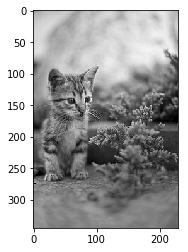

In [12]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img_path = './kitten.jpg'         # 上で持ってきた画像の場所
bgr_img = cv2.imread(img_path)    # カラー画像の読み込み
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY) # モノクロ画像に変換
gray_img = gray_img.astype("float32")/255  # 最大値で割って [0,1] の範囲に正規化
plt.imshow(gray_img, cmap='gray')  # 画像の表示
plt.show()

In [4]:
import numpy as np

filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])
print('Filter shape: ', filter_vals.shape)

Filter shape:  (4, 4)


In [5]:
# 4つのフィルタの準備
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

# フィルタの表示
for i, filt in enumerate(filters):
    print('Filter {0}:\n{1}'.format(i, filt))


Filter 0:
[[-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]
 [-1 -1  1  1]]
Filter 1:
[[ 1  1 -1 -1]
 [ 1  1 -1 -1]
 [ 1  1 -1 -1]
 [ 1  1 -1 -1]]
Filter 2:
[[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 1  1  1  1]]
Filter 3:
[[ 1  1  1  1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]]


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 上の4つのフィルタを使ったニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self, weight):
        super(Net, self).__init__()
        # 引数は [ミニバッチサイズ, チャンネル数，縦, 横] の 4 階テンソルなので，最後の2つを使う
        k_height, k_width = weight.shape[2:]
        # 4 つのグレースケール画像であることを仮定
        self.conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
        self.conv.weight = torch.nn.Parameter(weight)
        
    def forward(self, x):
        conv_x = self.conv(x)          # 畳込み演算の本体
        activated_x = F.relu(conv_x)   # 非線形変換 ReLU
        return conv_x, activated_x     # 結果と値を返す

# モデルとその値の初期化
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = Net(weight)

print(model)  # モデルの印刷

Net(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [0]:
def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        # Grab layer outputs
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

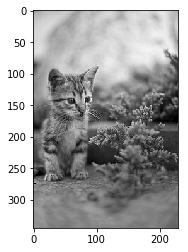

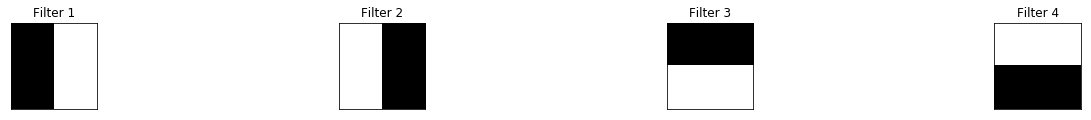

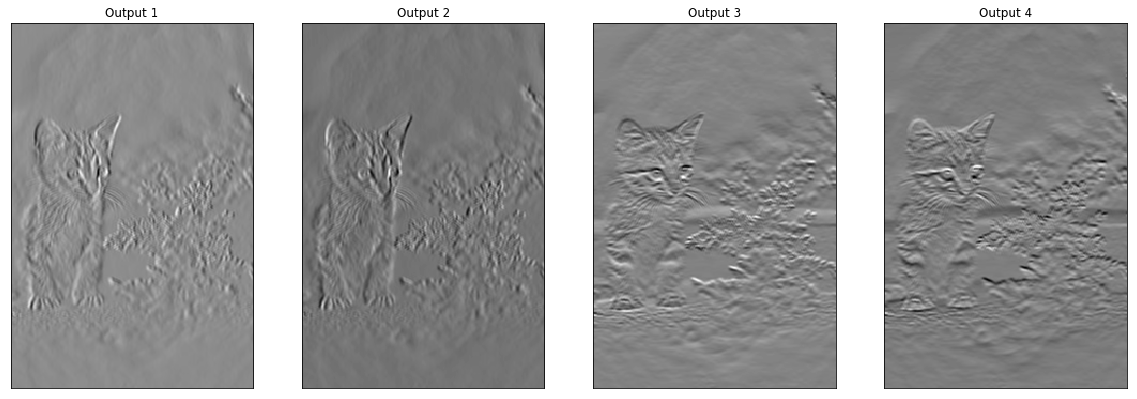

In [8]:
plt.imshow(gray_img, cmap='gray')   # オリジナル画像の表示

# フィルタの表示
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))
    
# 画像を入力テンソルへ変換
gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

# CNN によって変換されたデータ(画像)を得る
conv_layer, activated_layer = model(gray_img_tensor)

# 結果の表示
viz_layer(conv_layer)

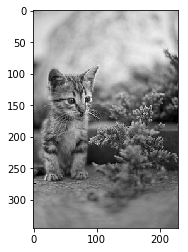

In [0]:
gray = cv2.cvtColor(bgr_img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

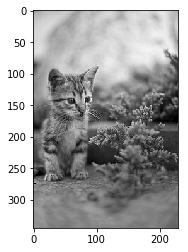

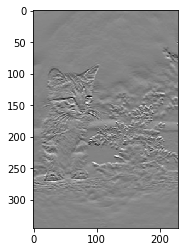

In [19]:
# 3x3 エッジ検出フィルタ，ソーベルフィルタ
sobel_y = np.array([[ -1, -2, -1],
                    [ 0, 0, 0],
                    [ 1, 2, 1]])

sobel_x = np.array([[ -1, 0, 1],
                    [ 0, 0, 0],
                    [ 1, 2, 1]])

plt.imshow(gray_img, cmap='gray')
plt.show()
filtered_image = cv2.filter2D(gray_img, -1, sobel_y)  # 実際の計算
plt.imshow(filtered_image, cmap='gray')               # 表示